# Tabela de Conteúdo



# Abordagem Inicial 

## Objetivo 

### Propor método para:
* encontrar representações comuns de diferentes modalidades sensoriais
* aumentar a quantidade de dados utilizados para redução de dimensionalidade do sinal
* melhorar a sensibilidade de análises MVPA posteriores 


### Importações necessárias para execução desse notebook

In [1]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split, LeaveOneOut
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.decomposition import PCA
from os.path import isfile, join
from os import listdir

import sys
import doctest
import matplotlib
import seaborn as sns
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set()


sys.path.append("../src/data")

/home/brain/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
from myMNE import makeMNE

# Carregando dados auditivos e visuais

In [3]:
PATH_AUD = '../data/raw/aud'
PATH_VIS = '../data/raw/vis'

PATH_INFO = '../data/raw/info_'


## Funções auxiliares para leitura do arquivo

In [4]:
def files_in_path(path):
    return [path+"/"+f for f in listdir(path) if isfile(join(path, f))]

# Getting data from MNE strutuct
def data_from_mne(files):
    return np.array([file.get_data().T for file in files])

In [5]:
# List of Files contained in the folder with path

path_file_aud = files_in_path(PATH_AUD)
path_file_vis = files_in_path(PATH_VIS)

In [6]:
# Reading files with the MNE library

files_aud = list(map(makeMNE, path_file_aud))
files_vis = list(map(makeMNE, path_file_vis))

In [7]:
# Getting data in numpy format
data_aud = data_from_mne(files_aud)
data_vis = data_from_mne(files_vis)

## Checking the shape in arrays

In [8]:
print("Data Aud with shape: {} (individual, raw, channels, trial)".format(data_aud.shape))
print("Data Vis with shape: {} (individual, raw, channels, trial)".format(data_vis.shape))

Data Aud with shape: (20, 539, 64, 240) (individual, raw, channels, trial)
Data Vis with shape: (20, 539, 64, 240) (individual, raw, channels, trial)


In [9]:
# Function to exposure separation:
# by definition in trial odd are the first exposure, and trial even the second exposure

def _exposure_1(data): 
    # [individual, raw, channels, trial]
    return data[::, ::, ::, 0:: 2]

def _exposure_2(data): 
    # [individual, raw, channels, trial]
    return data[::, ::, ::, 1:: 2]

# Auxiliary function to calculate the average in the bin
def _average(frame):
    return np.average(frame, axis=0)


In [10]:
## Splitting the exposures for all the individuals

aud_expo_1 = _exposure_1(data_aud)

aud_expo_2 = _exposure_2(data_aud) 

vis_expo_1 = _exposure_1(data_vis)

vis_expo_2 = _exposure_2(data_vis)

In [11]:
# Function for splitting and compute the average in the bins
def six_bin(exposure, indice_exposure, average=True):
    """Splitting array in bins for the first exposure,
    and compute the average

    Parameters
    ----------
    exposure: numpy.array (3-dimensions) [raw, channels, trial]
       Array containing data from an exposure.

    indice_exposure: numpy.array (1-dimension)

    Returns
    -------

    """

    zero = 39

    # Getting 2000 ms
    exposure_without_zero = exposure[zero:]

    s2 = indice_exposure

    media_por_trial = []

    for trial, ind_s2 in list(zip(exposure_without_zero.T, s2)):
        
        last_32_points = trial.T[int(ind_s2-32):int(ind_s2)]
        if(average):
            media_por_trial.append(_average(last_32_points).reshape(-1))
        else:
            media_por_trial.append(last_32_points)
    # ---------------------------------------------------------------------

    return np.array(media_por_trial).T

![recorte](../reports/figures/evaluate_trial.jpg)
Figura 01: Como recortar os trials.

In [12]:

def time_delay(name: str, export_as_indice=True):

    info_path = PATH_INFO+name

    infos = list(map(sio.loadmat, files_in_path(info_path)))
    
    por_pessoa = []
    for info in infos:
        
        #import pdb; pdb.set_trace()
        time_delay = info['report']['all_trials_delay'][0][0][0]
        if(export_as_indice):
        # second to milisecond, 4 from 250 Hz
            valores = (time_delay*250).astype(int)
        else:
            valores = time_delay
            
        por_pessoa.append(valores)
        
    return np.array(por_pessoa)



In [13]:
indice_s2_vis = time_delay('vis')
indice_s2_aud = time_delay('aud')

In [14]:
time_s2_vis = time_delay('vis',export_as_indice=False)
time_s2_aud = time_delay('aud',export_as_indice=False)

## Função de caracterização

In [15]:
def categoriza(valor):
    '''
    This is a test:
    >>> categoriza(0.750)
    1
    >>> categoriza(0.8749)
    1
    >>> categoriza(0.875)
    2
    >>> categoriza(0.900)
    2
    >>> categoriza(0.9899)
    2
    >>> categoriza(1.000)
    3
    >>> categoriza(1.001)
    3
    >>> categoriza(1.124)
    3
    >>> categoriza(1.125)
    4
    >>> categoriza(1.249)
    4
    >>> categoriza(1.250)
    5
    >>> categoriza(1.3748)
    5
    >>> categoriza(1.3759)
    6
    >>> categoriza(1.375)
    6
    >>> categoriza(1.520)
    6
    '''

    momento = int(valor * 1000)  # decimals=0)

    # print(momento)

    if((momento >= 750) and (momento < 875)):
        return (1)
    else:
        if ((momento >= 875) and (momento < 1000)):
            return (2)
        else:
            if ((momento >= 1000) and (momento < 1125)):
                return (3)
            else:
                if ((momento >= 1125) and (momento < 1250)):
                    return (4)
                else:
                    if ((momento >= 1250) and (momento < 1375)):
                        return (5)
                    else:
                        if ((momento >= 1375) and (momento <= 1520)):
                            return (6)

    return -1

In [16]:
classes_vis = [pd.DataFrame(time_s2_vis)[i].apply(categoriza) for i in range(120)]
classes_aud = [pd.DataFrame(time_s2_aud)[i].apply(categoriza) for i in range(120)]

In [17]:
classes_vis = pd.DataFrame(classes_vis).T
classes_aud = pd.DataFrame(classes_aud).T


### Teste da função de categorização

In [18]:
doctest.testmod(verbose=False)

TestResults(failed=0, attempted=15)

## Function to get the average in the bins
----

In [19]:
aud_expo_1_frames = list(map(six_bin, aud_expo_1, indice_s2_aud))
vis_expo_1_frames = list(map(six_bin, vis_expo_1, indice_s2_vis))


aud_expo_2_frames = list(map(six_bin, aud_expo_2, indice_s2_vis))
vis_expo_2_frames = list(map(six_bin, vis_expo_2, indice_s2_aud))

----

Com isso, iremos para o próximo passo, que consiste de aplicar o PCA para reduzir as dimensões redudantes presentes nos múltiplos canais.



![aquisicao](https://raw.githubusercontent.com/bruAristimunha/Across-Modalities/master/reports/figures/mapa_rapha.jpg) 

Figura 01: Diagrama de Reunião de Orientação. O ponto de interesse está na tabela para aplicação do PCA. Segundo os autores, eles empregaram em média 32 componentes +- 1


------------------------------------

# Studying of the number of components

In [20]:
def myPCA(data: np.array, return_data=False, n_components=0.99):

    pca_ = PCA(random_state=42, svd_solver='full', n_components=n_components)

    data = data.T

    data_ft = pca_.fit_transform(data)

    if(return_data):
        return data_ft
    else:
        return pca_

In [21]:
def myPCA_method(data): 
    return myPCA(data, return_data=False)
def myPCA_data(data): 
    return myPCA(data, return_data=True)

In [22]:
pcas = []

for person in aud_expo_1_frames:
    method_pca = myPCA_method(person)
    pcas.append(method_pca)
    
for person in vis_expo_1_frames:
    method_pca = myPCA_method(person)
    pcas.append(method_pca)
    
for person in aud_expo_2_frames:
    method_pca = myPCA_method(person)
    pcas.append(method_pca)
    
for person in vis_expo_2_frames:
    method_pca = myPCA_method(person)
    pcas.append(method_pca)

-------

In [23]:

font = {'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

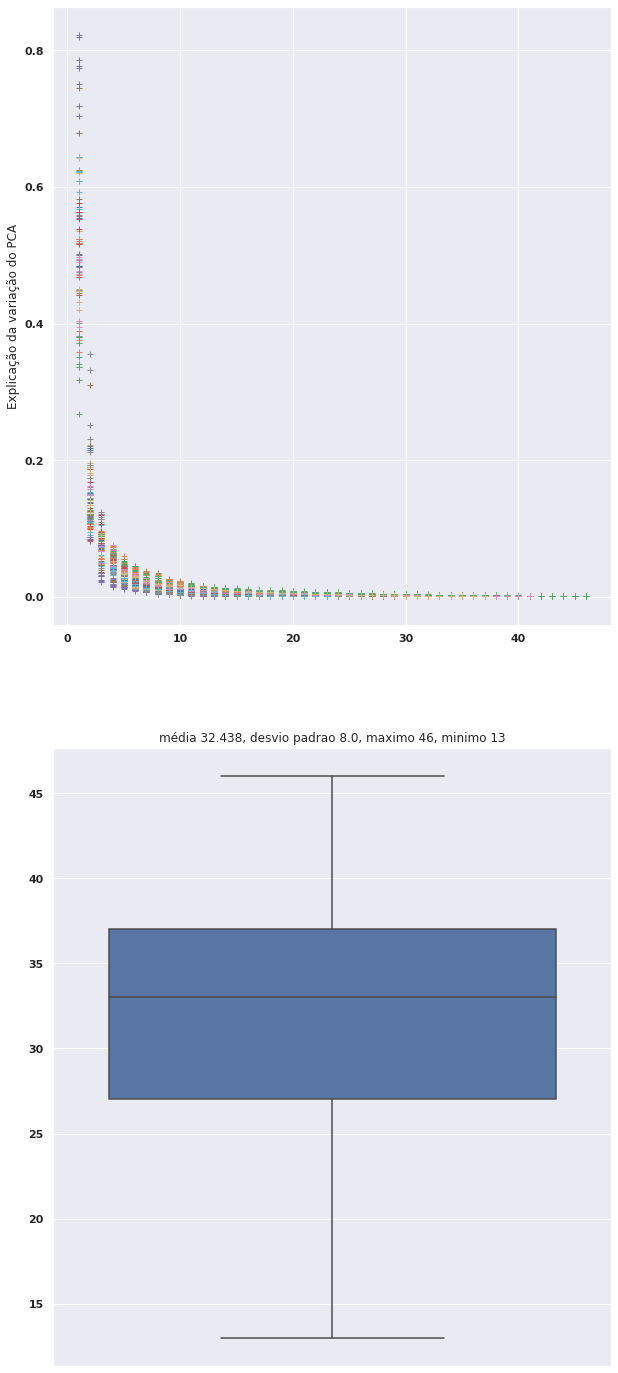

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 25))
method_pca = np.array(pcas).reshape(-1)
componentes = [pc.n_components_ for pc in method_pca]

for pc in method_pca:

    ax[0].plot(np.arange(1, pc.n_components_ + 1),
               pc.explained_variance_ratio_, '+', linewidth=2)
    ax[0].set_ylabel('Explicação da variação do PCA')

ax[1] = sns.boxplot(componentes, orient='vert', ax=ax[1])
ax[1].set_title("média {media:.5}, desvio padrao {std:.2}, maximo {maxi}, minimo {mini}".format(
    media=np.mean(componentes),
    std=np.std(componentes),
    maxi=np.max(componentes),
    mini=np.min(componentes)))
plt.show()

## Escolhemos $46$ como o número de componentes, sendo esse o número máximo de componentes necessários para explicar 99% dos dados.

In [25]:
def myPCA_47_comp(data, n_components=47):
    return myPCA(data, return_data=True, n_components=n_components)

In [26]:
#####################################################################

X_aud_expo_1_frames = []

for person in aud_expo_1_frames:

    data_pca = myPCA_47_comp(person)
    X_aud_expo_1_frames.append(data_pca)
#####################################################################

X_aud_expo_2_frames = []


for person in aud_expo_2_frames:

    data_pca = myPCA_47_comp(person)
    X_aud_expo_2_frames.append(data_pca)

#####################################################################

X_vis_expo_1_frames = []

for person in vis_expo_1_frames:

    data_pca = myPCA_47_comp(person)
    X_vis_expo_1_frames.append(data_pca)

#####################################################################

X_vis_expo_2_frames = []

for person in vis_expo_2_frames:

    data_pca = myPCA_47_comp(person)
    X_vis_expo_2_frames.append(data_pca)

#####################################################################

In [27]:
def to_DataFrame(X: list, classe) -> pd.DataFrame:

    X_preDataFrame = np.concatenate(np.array(X), axis=0)

    dataframe = pd.DataFrame(X_preDataFrame)

    dataframe = dataframe.reset_index()

    dataframe['person'] = (dataframe['index'] % 20)+1

    dataframe['trial'] = (dataframe['index'] % 120)+1
    #import pdb; pdb.set_trace()

    dataframe['class'] = np.concatenate(classe.values).reshape(-1)

    dataframe = dataframe.drop('index', 1)

    return dataframe

In [28]:
df_vis_1 = to_DataFrame(X_vis_expo_1_frames, classes_vis)
df_vis_2 = to_DataFrame(X_vis_expo_2_frames, classes_vis)

df_aud_1 = to_DataFrame(X_aud_expo_1_frames, classes_aud)
df_aud_2 = to_DataFrame(X_aud_expo_2_frames, classes_aud)

In [29]:
# Fixing shape

df_vis_1_without = np.array(vis_expo_2_frames).transpose([0, 2, 1])
df_vis_2_without = np.array(vis_expo_1_frames).transpose([0, 2, 1])
df_aud_1_without = np.array(aud_expo_1_frames).transpose([0, 2, 1])
df_aud_2_without = np.array(aud_expo_2_frames).transpose([0, 2, 1])


df_vis_1_without = to_DataFrame(df_vis_1_without, classes_vis)
df_vis_2_without = to_DataFrame(df_vis_2_without, classes_vis)

df_aud_1_without = to_DataFrame(df_aud_1_without, classes_aud)
df_aud_2_without = to_DataFrame(df_aud_2_without, classes_aud)

# Classification process

## With PCA processing

In [30]:
df_vis_1.to_csv("../data/processed/visual_exposure_1.csv", index=None)
df_vis_2.to_csv("../data/processed/visual_exposure_2.csv", index=None)

df_aud_1.to_csv("../data/processed/auditory_exposure_1.csv", index=None)
df_aud_2.to_csv("../data/processed/auditory_exposure_2.csv", index=None)

In [31]:

df_vis_1 = pd.read_csv("../data/processed/visual_exposure_1.csv")
df_vis_2 = pd.read_csv("../data/processed/visual_exposure_2.csv")

df_aud_1 = pd.read_csv("../data/processed/auditory_exposure_1.csv")
df_aud_2 = pd.read_csv("../data/processed/auditory_exposure_2.csv")

In [32]:


def makeCatPlot(df, categoria, exposicao):
    df_result = []

    X = df.drop(['person',  'trial', 'class'],1)
    y = df['class']
    loo = LeaveOneOut()
    pbar = tqdm( total=loo.get_n_splits(X))
    
    for train_index, test_index in loo.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = GaussianNB()
        #import pdb; pdb.set_trace()
        clf = clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        df_result.append([y_pred,y_test.values,categoria,exposicao])
        pbar.update(1)
    return df_result

In [33]:
resu_vis_1 = makeCatPlot(df_vis_1,'Visual','E1')

In [34]:
resu_vis_2 = makeCatPlot(df_vis_2,'Visual','E2')

In [35]:
resu_aud_1 = makeCatPlot(df_aud_1,'Auditory','E1')

In [36]:
resu_aud_2 = makeCatPlot(df_aud_2,'Auditory','E2')

In [37]:
merge = np.concatenate([resu_vis_1,resu_vis_2, resu_aud_1, resu_aud_2])

plotar = pd.DataFrame(merge)

plotar.to_csv("../data/processed/resu_fig5.csv",index=None)

plotar[0] = plotar[0].astype(int)
plotar[1] = plotar[1].astype(int)

plotar.columns = ['Predicted Bin','Real Bin','Modality','Exposures']

In [38]:
#Vermelho auditory
#Azul Visual


In [39]:
exposicao1 = plotar[plotar['Exposures']=='E1']

exposicao1_aud = exposicao1[exposicao1['Modality']=='Auditory']
exposicao1_vis = exposicao1[exposicao1['Modality']=='Visual']


exposicao2 = plotar[plotar['Exposures']=='E2']

exposicao2_aud = exposicao2[exposicao2['Modality']=='Auditory']
exposicao2_vis = exposicao2[exposicao2['Modality']=='Visual']


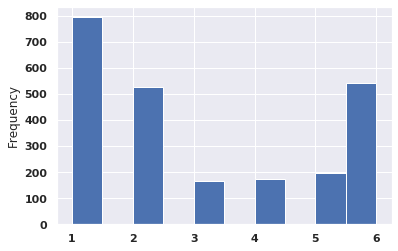

In [40]:
exposicao1_aud['Predicted Bin'].plot.hist()

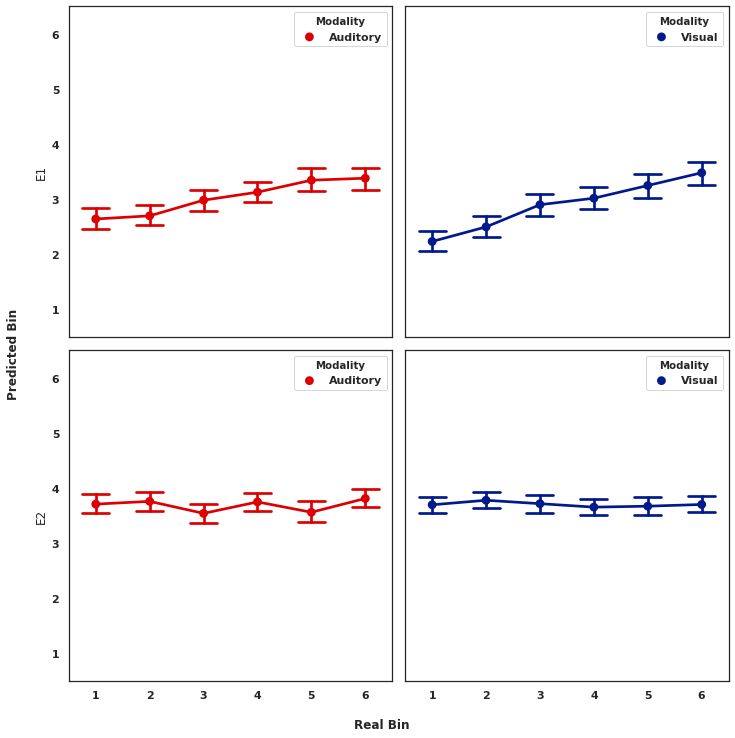

In [41]:

sns.set(style='white')

fig, ax = plt.subplots(figsize=(10, 10), nrows=2,
                       ncols=2, sharex=True, sharey=True)

g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                capsize=.5, palette=['#de0000'], height=10, aspect=1,
                kind="point", data=exposicao1_aud, sharey=False, sharex=False, seed=42, ax=ax[0][0])

plt.close(g.fig)


ax[0][0].set(ylim=(0.5, 6.5))
ax[0][0].set(ylabel="E1", xlabel="")

g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                capsize=.5, palette=['#001a8d'], height=10, aspect=1,
                kind="point", data=exposicao1_vis, sharey=True, sharex=True, seed=42, ax=ax[0][1])
ax[0][1].set(ylabel="", xlabel='')
plt.close(g.fig)
g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                capsize=.5, palette=['#de0000'], height=10, aspect=1,
                kind="point", data=exposicao2_aud, sharey=False, sharex=False, seed=42, ax=ax[1][0])
ax[1][0].set(ylim=(0.5, 6.5))
ax[1][0].set(ylabel="E2", xlabel="")
plt.close(g.fig)
g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                capsize=.5, palette=['#001a8d'], height=10, aspect=1,
                kind="point", data=exposicao2_vis, sharey=False, sharex=False, seed=42, ax=ax[1][1])
plt.close(g.fig)
ax[1][1].set(ylim=(0.5, 6.5))
ax[1][1].set(ylabel="", xlabel='')


fig.tight_layout()
fig.text(0.5, -0.02, 'Real Bin', ha='center')
fig.text(-0.02, 0.5, 'Predicted Bin', va='center', rotation='vertical')

plt.show()

In [42]:
print("Classificação nos Dados Visual, exposição 1")

y_test = exposicao1_vis['Predicted Bin'].values
y_pred = exposicao1_vis['Real Bin'].values


print(classification_report(y_test, y_pred))

Classificação nos Dados Visual, exposição 1
              precision    recall  f1-score   support

           1       0.59      0.20      0.30      1089
           2       0.10      0.16      0.12       262
           3       0.05      0.15      0.08       125
           4       0.07      0.16      0.09       191
           5       0.07      0.14      0.10       188
           6       0.29      0.23      0.26       545

    accuracy                           0.19      2400
   macro avg       0.20      0.17      0.16      2400
weighted avg       0.36      0.19      0.23      2400



In [43]:
print("Classificação nos Dados Visual, exposição 2")

y_test = exposicao2_vis['Predicted Bin'].values
y_pred = exposicao2_vis['Real Bin'].values


print(classification_report(y_test, y_pred))

Classificação nos Dados Visual, exposição 2
              precision    recall  f1-score   support

           1       0.14      0.16      0.15       320
           2       0.07      0.11      0.08       266
           3       0.04      0.09      0.06       187
           4       0.44      0.18      0.26      1063
           5       0.07      0.14      0.09       164
           6       0.15      0.16      0.16       400

    accuracy                           0.16      2400
   macro avg       0.15      0.14      0.13      2400
weighted avg       0.25      0.16      0.18      2400



In [44]:
print("Classificação nos Dados Auditivo, exposição 1")
y_test = exposicao1_aud['Predicted Bin'].values
y_pred = exposicao1_aud['Real Bin'].values

print(classification_report(y_test, y_pred))

Classificação nos Dados Auditivo, exposição 1
              precision    recall  f1-score   support

           1       0.40      0.19      0.26       795
           2       0.21      0.17      0.19       526
           3       0.06      0.14      0.09       167
           4       0.09      0.22      0.12       172
           5       0.06      0.12      0.08       198
           6       0.30      0.24      0.27       542

    accuracy                           0.19      2400
   macro avg       0.19      0.18      0.17      2400
weighted avg       0.26      0.19      0.21      2400



In [48]:
import seaborn as sns
sns.set(style='white')

def plot_cat(aud_1, aud_2, vis_1, vis_2, color=True):
    
    if(color):    
        fig, ax = plt.subplots(figsize=(10, 10), nrows=2,
                               ncols=2, sharex=True, sharey=True)

        g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                        capsize=.5, palette=['#de0000'], height=10, aspect=1,
                        kind="point", data=aud_1, sharey=False, sharex=False, seed=42, ax=ax[0][0])

        plt.close(g.fig)


        ax[0][0].set(ylim=(0.5, 6.5))
        ax[0][0].set(ylabel="E1", xlabel="")

        g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                        capsize=.5, palette=['#001a8d'], height=10, aspect=1,
                        kind="point", data=vis_1, sharey=True, sharex=True, seed=42, ax=ax[0][1])
        ax[0][1].set(ylabel="", xlabel='')
        plt.close(g.fig)
        g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                        capsize=.5, palette=['#de0000'], height=10, aspect=1,
                        kind="point", data=aud_2, sharey=False, sharex=False, seed=42, ax=ax[1][0])
        ax[1][0].set(ylim=(0.5, 6.5))
        ax[1][0].set(ylabel="E2", xlabel="")
        plt.close(g.fig)
        g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                        capsize=.5, palette=['#001a8d'], height=10, aspect=1,
                        kind="point", data=vis_2, sharey=False, sharex=False, seed=42, ax=ax[1][1])
        plt.close(g.fig)
        ax[1][1].set(ylim=(0.5, 6.5))
        ax[1][1].set(ylabel="", xlabel='')


        fig.tight_layout()
        fig.text(0.5, -0.02, 'Real Bin', ha='center')
        fig.text(-0.02, 0.5, 'Predicted Bin', va='center', rotation='vertical')

        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(10, 10), nrows=2,
                               ncols=2, sharex=True, sharey=True)

        g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                        capsize=.5, height=10, aspect=1,
                        kind="point", data=aud_1, sharey=False, sharex=False, seed=42, ax=ax[0][0])

        plt.close(g.fig)


        ax[0][0].set(ylim=(0.5, 6.5))
        ax[0][0].set(ylabel="E1", xlabel="")

        g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                        capsize=.5, height=10, aspect=1,
                        kind="point", data=vis_1, sharey=True, sharex=True, seed=42, ax=ax[0][1])
        ax[0][1].set(ylabel="", xlabel='')
        plt.close(g.fig)
        g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                        capsize=.5,  height=10, aspect=1,
                        kind="point", data=aud_2, sharey=False, sharex=False, seed=42, ax=ax[1][0])
        ax[1][0].set(ylim=(0.5, 6.5))
        ax[1][0].set(ylabel="E2", xlabel="")
        plt.close(g.fig)
        g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                        capsize=.5, height=10, aspect=1,
                        kind="point", data=vis_2, sharey=False, sharex=False, seed=42, ax=ax[1][1])
        plt.close(g.fig)
        ax[1][1].set(ylim=(0.5, 6.5))
        ax[1][1].set(ylabel="", xlabel='')


        fig.tight_layout()
        fig.text(0.5, -0.02, 'Real Bin', ha='center')
        fig.text(-0.02, 0.5, 'Predicted Bin', va='center', rotation='vertical')

        plt.show()

In [45]:
print("Classificação nos Dados Auditivo, exposição 2")
y_test = exposicao2_aud['Predicted Bin'].values
y_pred = exposicao2_aud['Real Bin'].values
print(classification_report(y_test, y_pred))

Classificação nos Dados Auditivo, exposição 2
              precision    recall  f1-score   support

           1       0.14      0.18      0.16       301
           2       0.22      0.18      0.20       524
           3       0.10      0.15      0.12       242
           4       0.24      0.20      0.22       512
           5       0.05      0.10      0.07       187
           6       0.30      0.21      0.24       634

    accuracy                           0.18      2400
   macro avg       0.18      0.17      0.17      2400
weighted avg       0.21      0.18      0.19      2400



## Without PCA

In [46]:
resu_vis_1_w = makeCatPlot(df_vis_1_without,'Visual','E1')
resu_vis_2_w = makeCatPlot(df_vis_2_without,'Visual','E2')

resu_aud_1_w = makeCatPlot(df_aud_1_without,'Auditory','E1')
resu_aud_2_w = makeCatPlot(df_aud_2_without,'Auditory','E2')

In [47]:
merge_w = np.concatenate([resu_vis_1_w,resu_vis_2_w, resu_aud_1_w, resu_aud_2_w])

plotar_w = pd.DataFrame(merge_w)

plotar_w[0] = plotar_w[0].astype(int)
plotar_w[1] = plotar_w[1].astype(int)

plotar_w.columns = ['Predicted Bin','Real Bin','Modality','Exposures']

exposicao1_w = plotar_w[plotar_w['Exposures']=='E1']

exposicao1_aud_w = exposicao1_w[exposicao1_w['Modality']=='Auditory']
exposicao1_vis_w = exposicao1_w[exposicao1_w['Modality']=='Visual']


exposicao2_w = plotar_w[plotar_w['Exposures']=='E2']

exposicao2_aud_w = exposicao2_w[exposicao2_w['Modality']=='Auditory']
exposicao2_vis_w = exposicao2_w[exposicao2_w['Modality']=='Visual']


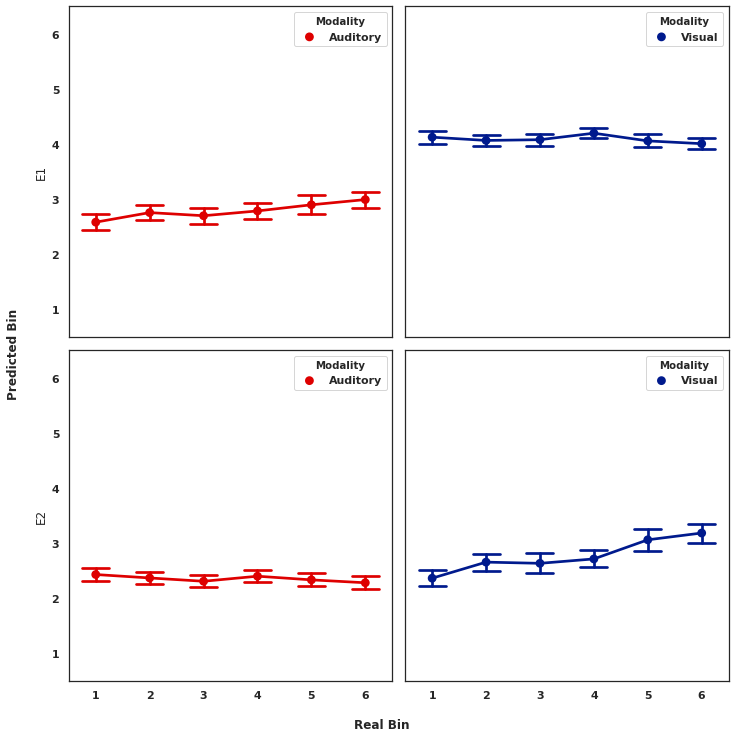

In [49]:
plot_cat(exposicao1_aud_w, exposicao2_aud_w, exposicao1_vis_w, exposicao2_vis_w)

In [50]:
print("Classificação nos Dados Visual, exposição 1")

y_test = exposicao1_vis_w['Predicted Bin'].values
y_pred = exposicao1_vis_w['Real Bin'].values


print(classification_report(y_test, y_pred))

Classificação nos Dados Visual, exposição 1
              precision    recall  f1-score   support

           1       0.04      0.19      0.06        74
           2       0.07      0.21      0.11       141
           3       0.03      0.13      0.04        79
           4       0.69      0.19      0.29      1646
           5       0.04      0.13      0.06       115
           6       0.12      0.14      0.13       345

    accuracy                           0.18      2400
   macro avg       0.16      0.16      0.12      2400
weighted avg       0.50      0.18      0.23      2400



In [51]:
print("Classificação nos Dados Visual, exposição 2")

y_test = exposicao2_vis_w['Predicted Bin'].values
y_pred = exposicao2_vis_w['Real Bin'].values


print(classification_report(y_test, y_pred))

Classificação nos Dados Visual, exposição 2
              precision    recall  f1-score   support

           1       0.41      0.18      0.25       850
           2       0.15      0.18      0.16       366
           3       0.23      0.18      0.20       500
           4       0.07      0.16      0.09       186
           5       0.09      0.18      0.12       170
           6       0.18      0.23      0.20       328

    accuracy                           0.18      2400
   macro avg       0.19      0.18      0.17      2400
weighted avg       0.25      0.18      0.20      2400



In [52]:
print("Classificação nos Dados Auditivo, exposição 1")
y_test = exposicao1_aud_w['Predicted Bin'].values
y_pred = exposicao1_aud_w['Real Bin'].values

print(classification_report(y_test, y_pred))

Classificação nos Dados Auditivo, exposição 1
              precision    recall  f1-score   support

           1       0.18      0.17      0.17       411
           2       0.43      0.18      0.26       990
           3       0.16      0.14      0.15       427
           4       0.05      0.18      0.08       130
           5       0.08      0.20      0.11       143
           6       0.15      0.21      0.17       299

    accuracy                           0.18      2400
   macro avg       0.17      0.18      0.16      2400
weighted avg       0.26      0.18      0.20      2400



In [53]:
print("Classificação nos Dados Auditivo, exposição 2")
y_test = exposicao2_aud_w['Predicted Bin'].values
y_pred = exposicao2_aud_w['Real Bin'].values
print(classification_report(y_test, y_pred))

Classificação nos Dados Auditivo, exposição 2
              precision    recall  f1-score   support

           1       0.11      0.15      0.13       292
           2       0.66      0.18      0.29      1536
           3       0.15      0.17      0.16       335
           4       0.00      0.12      0.01        16
           5       0.04      0.14      0.07       112
           6       0.05      0.18      0.07       109

    accuracy                           0.17      2400
   macro avg       0.17      0.16      0.12      2400
weighted avg       0.46      0.17      0.23      2400



## PCA in the train

In [54]:

def makeCatPlot_PCA_in_train(df, categoria, exposicao):
    df_result = []

    X = df.drop(['person',  'trial', 'class'],1)
    y = df['class']
    loo = LeaveOneOut()
    pbar = tqdm( total=loo.get_n_splits(X))
    
    for train_index, test_index in loo.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = GaussianNB()

        pca_ = PCA(random_state=42, svd_solver='full', n_components=0.99)
    
        pca = pca_.fit(X_train)

        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)

        
        clf = clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        df_result.append([y_pred,y_test.values,categoria,exposicao])
        pbar.update(1)
    return df_result

In [55]:
resu_vis_1_pca = makeCatPlot_PCA_in_train(df_vis_1_without,'Visual','E1')
resu_vis_2_pca = makeCatPlot_PCA_in_train(df_vis_2_without,'Visual','E2')

resu_aud_1_pca = makeCatPlot_PCA_in_train(df_aud_1_without,'Auditory','E1')
resu_aud_2_pca = makeCatPlot_PCA_in_train(df_aud_2_without,'Auditory','E2')

In [56]:
merge_pca = np.concatenate([resu_vis_1_pca,resu_vis_2_pca, resu_aud_1_pca, resu_aud_2_pca])

plotar_pca = pd.DataFrame(merge_pca)

In [57]:
plotar_pca[0] = plotar_pca[0].astype(int)
plotar_pca[1] = plotar_pca[1].astype(int)

plotar_pca.columns = ['Predicted Bin','Real Bin','Modality','Exposures']

exposicao1_pca = plotar_pca[plotar_pca['Exposures']=='E1']

exposicao1_aud_pca = exposicao1_pca[exposicao1_pca['Modality']=='Auditory']
exposicao1_vis_pca = exposicao1_pca[exposicao1_pca['Modality']=='Visual']


exposicao2_pca = plotar_pca[plotar_pca['Exposures']=='E2']

exposicao2_aud_pca = exposicao2_pca[exposicao2_pca['Modality']=='Auditory']
exposicao2_vis_pca = exposicao2_pca[exposicao2_pca['Modality']=='Visual']


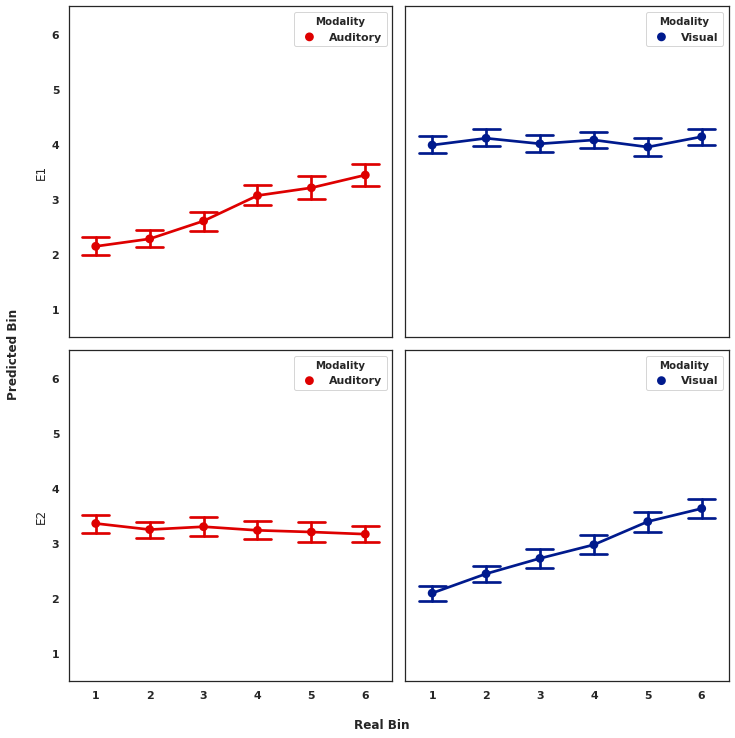

In [58]:
plot_cat(exposicao1_aud_pca, exposicao2_aud_pca, exposicao1_vis_pca, exposicao2_vis_pca, True)

## Comparativo entre todos os cenários:

In [59]:
exposicao1_aud_pca['Modality'] = 'PCA_in_train'
exposicao1_aud_w['Modality'] = 'Without PCA'
exposicao1_aud['Modality'] = 'PCA_all'


exposicao1_vis_pca['Modality'] = 'PCA_in_train'
exposicao1_vis_w['Modality'] = 'Without PCA'
exposicao1_vis['Modality'] = 'PCA_all'

exposicao2_aud_pca['Modality'] = 'PCA_in_train'
exposicao2_aud_w['Modality'] = 'Without PCA'
exposicao2_aud['Modality'] = 'PCA_all'

exposicao2_vis_pca['Modality'] = 'PCA_in_train'
exposicao2_vis_w['Modality'] = 'Without PCA'
exposicao2_vis['Modality'] = 'PCA_all'

In [60]:
all_exp_aud_1 = pd.concat([exposicao1_aud_pca,exposicao1_aud_w,exposicao1_aud],ignore_index=True)
all_exp_aud_2 = pd.concat([exposicao2_aud_pca,exposicao2_aud_w,exposicao2_aud],ignore_index=True)

all_exp_vis_1 = pd.concat([exposicao1_vis_pca,exposicao1_vis_w,exposicao1_vis],ignore_index=True)
all_exp_vis_2 = pd.concat([exposicao2_vis_pca,exposicao2_vis_w,exposicao2_vis],ignore_index=True)

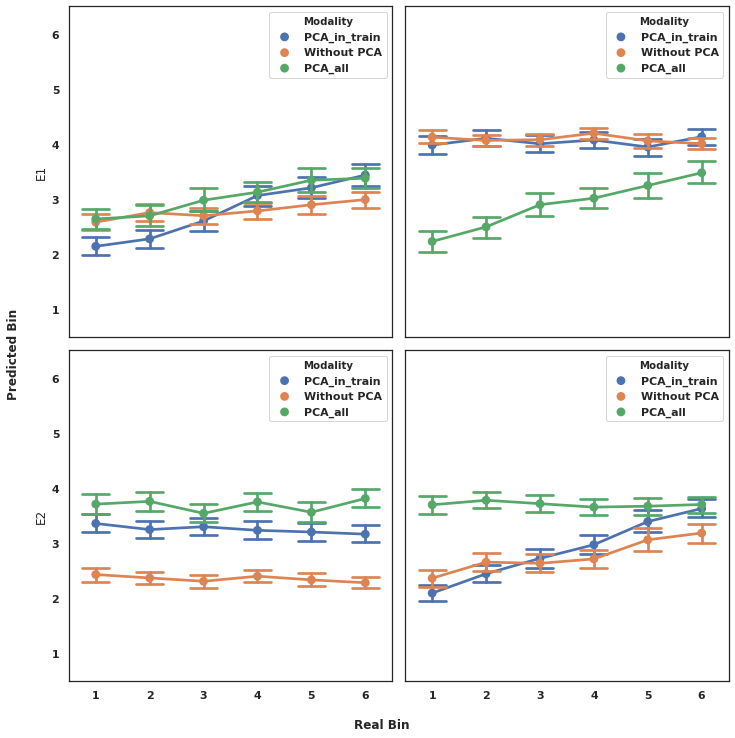

In [61]:
plot_cat(all_exp_aud_1, all_exp_aud_2, all_exp_vis_1, all_exp_vis_2,False)

# Balancelamento das classes


## Distribuição das classes

In [62]:
def plot_balanceamento(df, ax, name='Real Bin'):
    return df[name].plot.hist(bins=6, ax=ax)

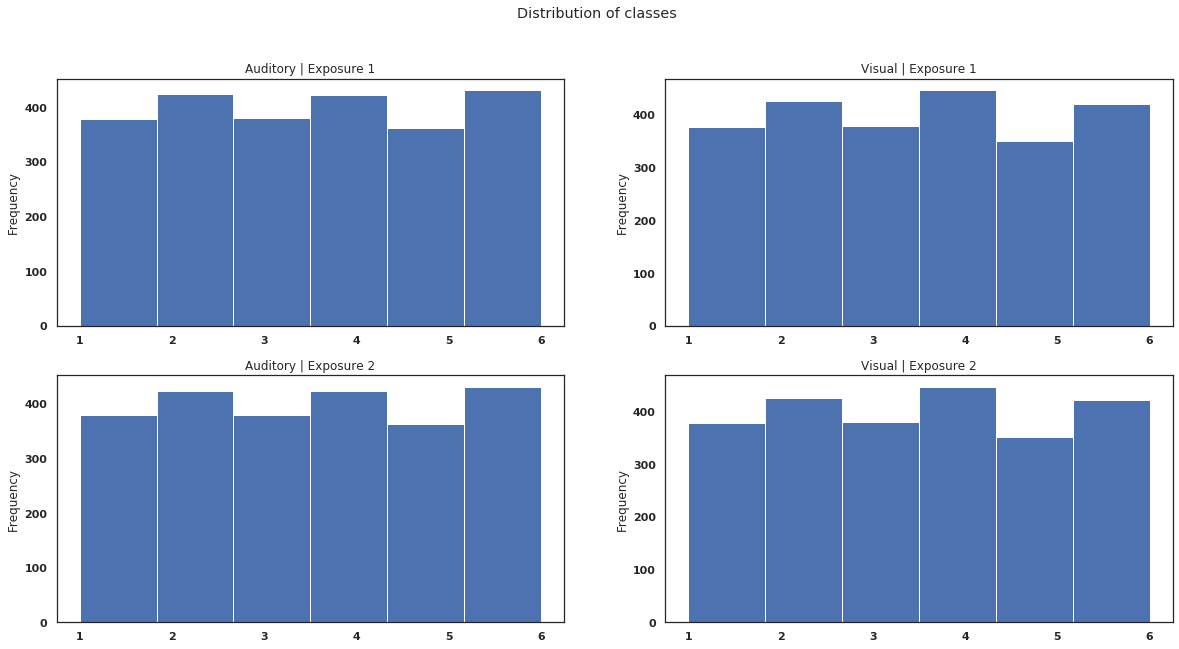

In [63]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,10))

plot_balanceamento(exposicao1_aud_w, ax=ax[0][0])
ax[0][0].set_title("Auditory | Exposure 1")
plot_balanceamento(exposicao2_aud_w, ax=ax[1][0])
ax[1][0].set_title("Auditory | Exposure 2")

plot_balanceamento(exposicao1_vis_w, ax=ax[0][1])
ax[0][1].set_title("Visual | Exposure 1")

plot_balanceamento(exposicao2_vis_w, ax=ax[1][1])
ax[1][1].set_title("Visual | Exposure 2")

fig.suptitle("Distribution of classes")
plt.show()

## Predição Sem PCA

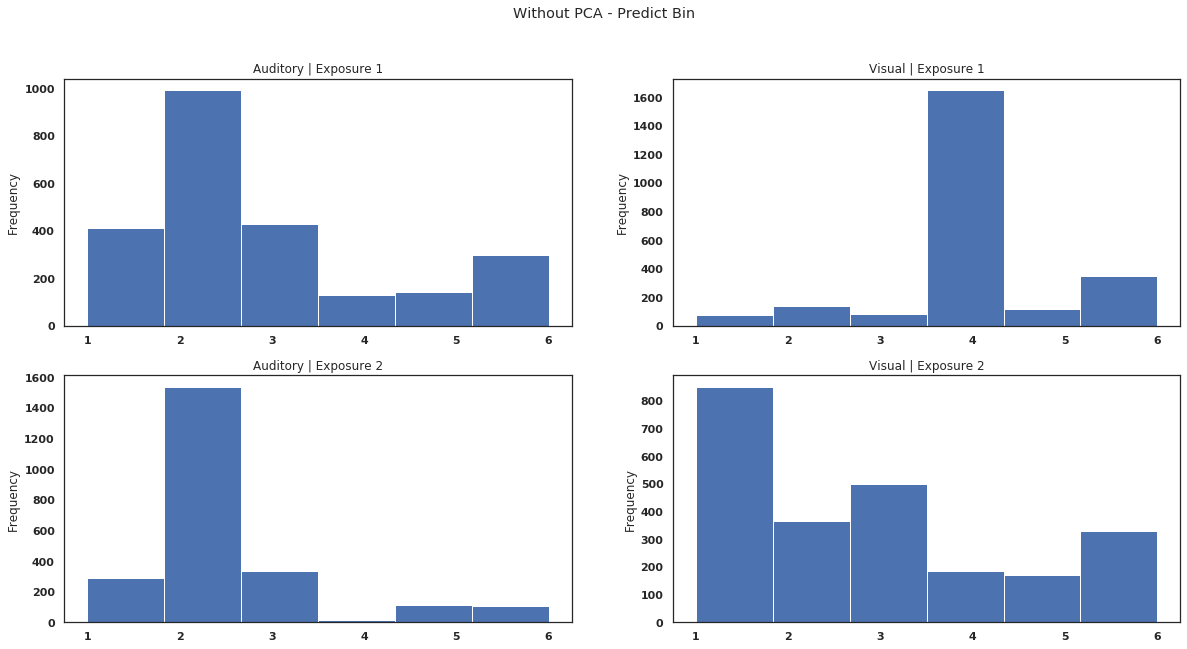

In [64]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,10))

plot_balanceamento(exposicao1_aud_w, ax=ax[0][0], name='Predicted Bin')
ax[0][0].set_title("Auditory | Exposure 1")
plot_balanceamento(exposicao2_aud_w, ax=ax[1][0], name='Predicted Bin')
ax[1][0].set_title("Auditory | Exposure 2")

plot_balanceamento(exposicao1_vis_w, ax=ax[0][1], name='Predicted Bin')
ax[0][1].set_title("Visual | Exposure 1")

plot_balanceamento(exposicao2_vis_w, ax=ax[1][1], name='Predicted Bin')
ax[1][1].set_title("Visual | Exposure 2")

fig.suptitle("Without PCA - Predict Bin")
plt.show()

## Predição Com PCA

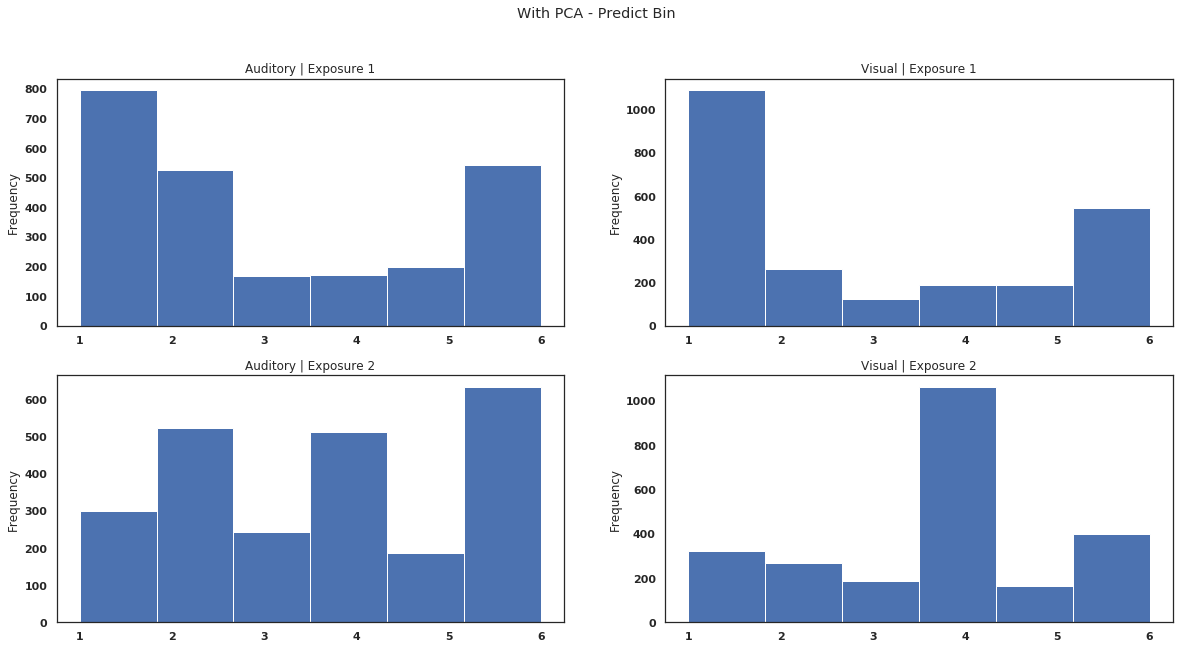

In [65]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,10))

plot_balanceamento(exposicao1_aud, ax=ax[0][0], name='Predicted Bin')
ax[0][0].set_title("Auditory | Exposure 1")
plot_balanceamento(exposicao2_aud, ax=ax[1][0], name='Predicted Bin')
ax[1][0].set_title("Auditory | Exposure 2")

plot_balanceamento(exposicao1_vis, ax=ax[0][1], name='Predicted Bin')
ax[0][1].set_title("Visual | Exposure 1")

plot_balanceamento(exposicao2_vis, ax=ax[1][1], name='Predicted Bin')
ax[1][1].set_title("Visual | Exposure 2")

fig.suptitle("With PCA - Predict Bin")
plt.show()

* [x] - 1) No PCA -> tente fazer a classificação sem o PCA

* [x] - 2) Na atribuição dos rótulos às médias -> Olhe manualmente para um indivíduo as séries, as médias e os rótulos e veja se está ok.

* [x] - 3) Na parte de aprendizado de máquina -> Coloque um exemplo simples para classificação com a mesma estrutura dos seus dados. Por exemplo, coloque que a média é sempre 10 para a categoria 1, 20 para a 2 e assim por diante. Veja se os resultados e gráficos ficam bons ou não. 

* [x] - 4) Veja o balanceamento de trials nas 6 categorias. Veja se a duração do trial corresponde à categoria correta.

* [ ] - 5) Em algum lugar obscuro do código.

# Checagem do rótulos às médias

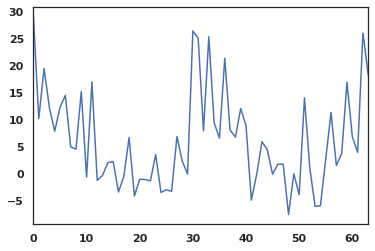

In [66]:
df_aud_1_without.loc[0][:-3].plot()

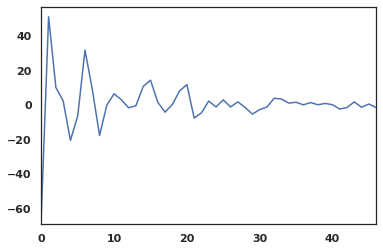

In [67]:
df_aud_1.loc[0][:-3].plot()

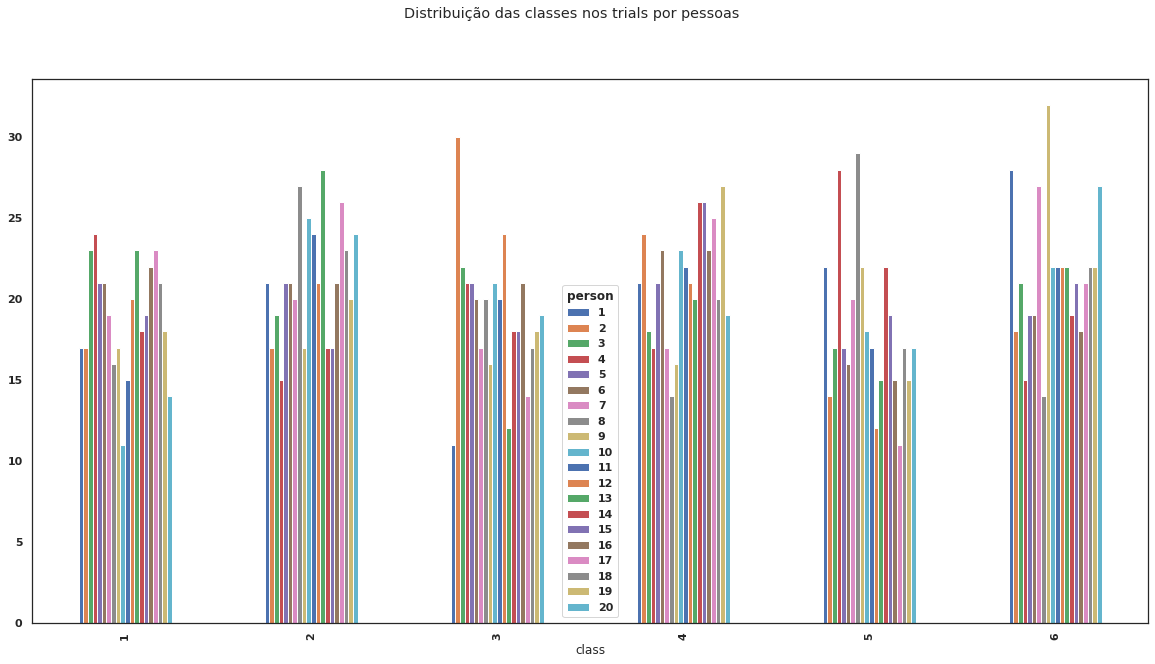

In [68]:
contagem_pessoas_classe = df_aud_1.groupby(['person','class']).size().unstack()

fig, ax = plt.subplots(figsize=(20,10))

ax = contagem_pessoas_classe.T.plot.bar(ax=ax)

fig = fig.suptitle("Distribuição das classes nos trials por pessoas")


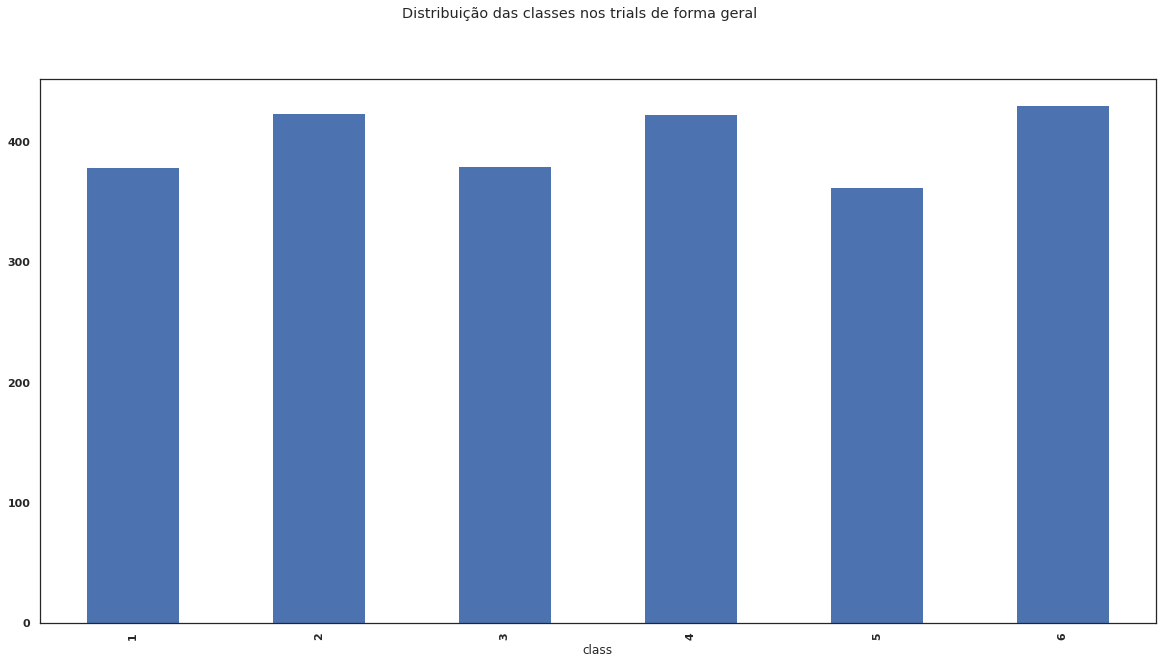

In [69]:
contagem_classe = df_aud_1.groupby(['class']).size()
fig, ax = plt.subplots(figsize=(20,10))

ax = contagem_classe.T.plot.bar(ax=ax)

fig = fig.suptitle("Distribuição das classes nos trials de forma geral")


# Checagem do aprendizado de máquina

In [70]:
simulation = [10,20,30,40,50,60]*450
classe = [1,2,3,4,5,6]*450
pessoas = ['1','2','3','4','5','6']*450
trial = ['1','2','3','4','5','6']*450

In [71]:
simu = pd.DataFrame([simulation,classe, pessoas, trial]).T

simu.columns = ['X_simulation','class','person', 'trial']
simu['class'] = simu['class'].astype(int)
simu['X_simulation'] = simu['X_simulation'].astype(int)


In [72]:
simulation = makeCatPlot(simu,'Simulation','Teste')

In [73]:
plotar_simulation = pd.DataFrame(simulation)

plotar_simulation[0] = plotar_simulation[0].astype(int)
plotar_simulation[1] = plotar_simulation[1].astype(int)

In [74]:
plotar_simulation.columns = ['Predicted Bin','Real Bin','Modality','Exposures']

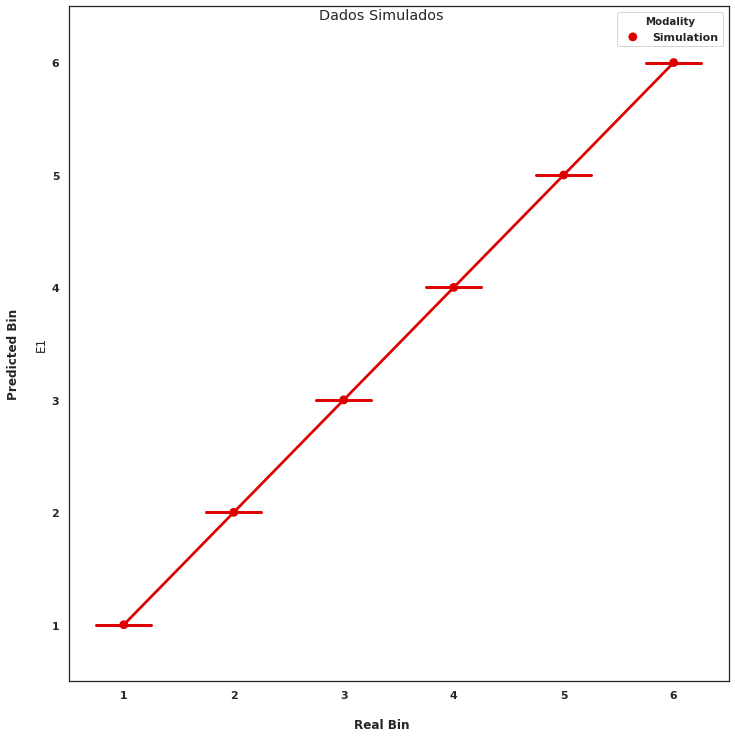

In [75]:
sns.set(style='white')

fig, ax = plt.subplots(figsize=(10, 10), nrows=1,
                       ncols=1, sharex=True, sharey=True)

g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                capsize=.5, palette=['#de0000'], height=10, aspect=1,
                kind="point", data=plotar_simulation, sharey=False, sharex=False, seed=42, ax=ax)

plt.close(g.fig)


ax.set(ylim=(0.5, 6.5))
ax.set(ylabel="E1", xlabel="")


fig.tight_layout()
fig.text(0.5, -0.02, 'Real Bin', ha='center')
fig.text(-0.02, 0.5, 'Predicted Bin', va='center', rotation='vertical')
fig.suptitle("Dados Simulados")
plt.show()

## Inspeção por permutação

In [76]:
def makeCatPlot_Inspeção(df, categoria, exposicao, plot=True):
    df_result = []

    X = df.drop(['person',  'trial', 'class'],1)
    y = df['class']

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=42)
    
    
    clf = GaussianNB()
    
    cv_score = cross_val_score(clf,X_train,y_train,cv=10).mean()
    
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    df_result.append([y_pred,y_test,cv_score, categoria,exposicao])
    
    if(plot):
        result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                    random_state=42, n_jobs=2)
        sorted_idx = result.importances_mean.argsort()

        fig, ax = plt.subplots(figsize=(10,25))
        ax.boxplot(result.importances[sorted_idx].T,
                   vert=False, labels=X_train.columns[sorted_idx])
        ax.set_title("Permutation Importances \n| Modality "+categoria+' | Exposure: '+ exposicao)
        fig.tight_layout()
        plt.show()
        
    return df_result

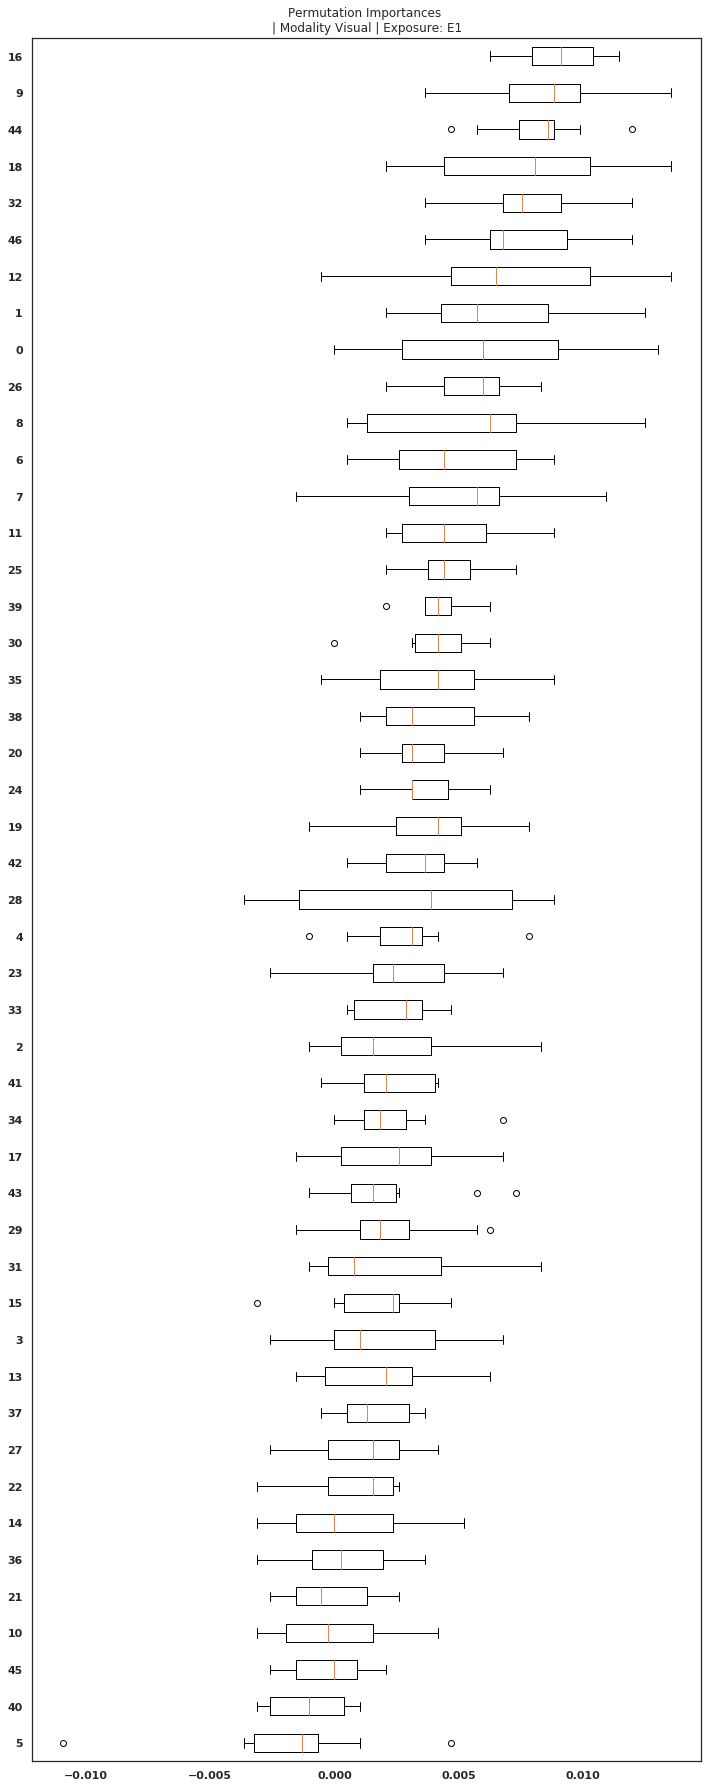

In [77]:
resu_vis_1_w_i = makeCatPlot_Inspeção(df_vis_1,'Visual','E1')


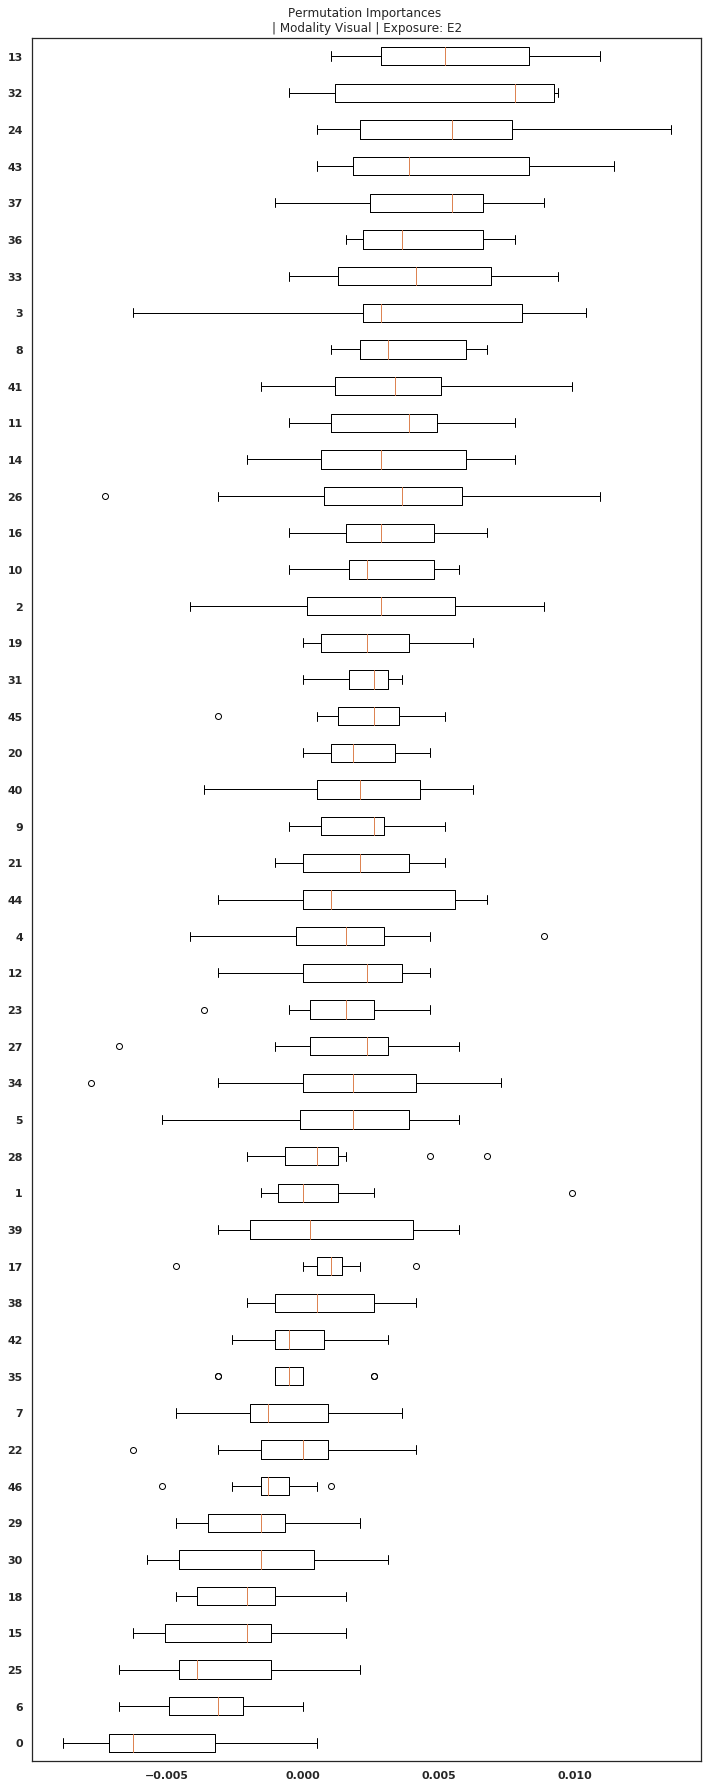

In [78]:
resu_vis_2_w_i = makeCatPlot_Inspeção(df_vis_2,'Visual','E2')


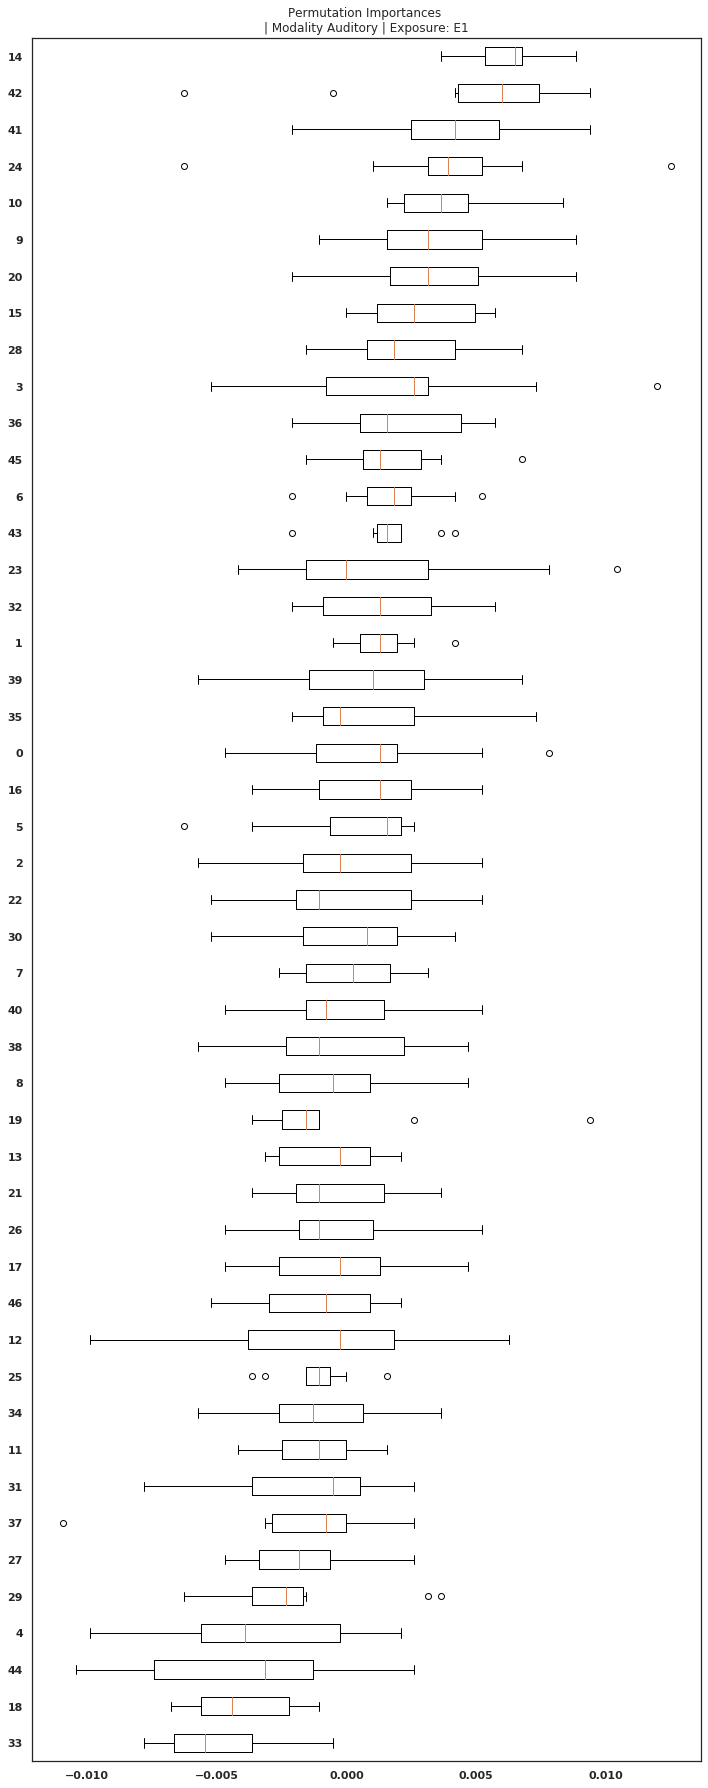

In [79]:
resu_aud_1_w_i = makeCatPlot_Inspeção(df_aud_1,'Auditory','E1')


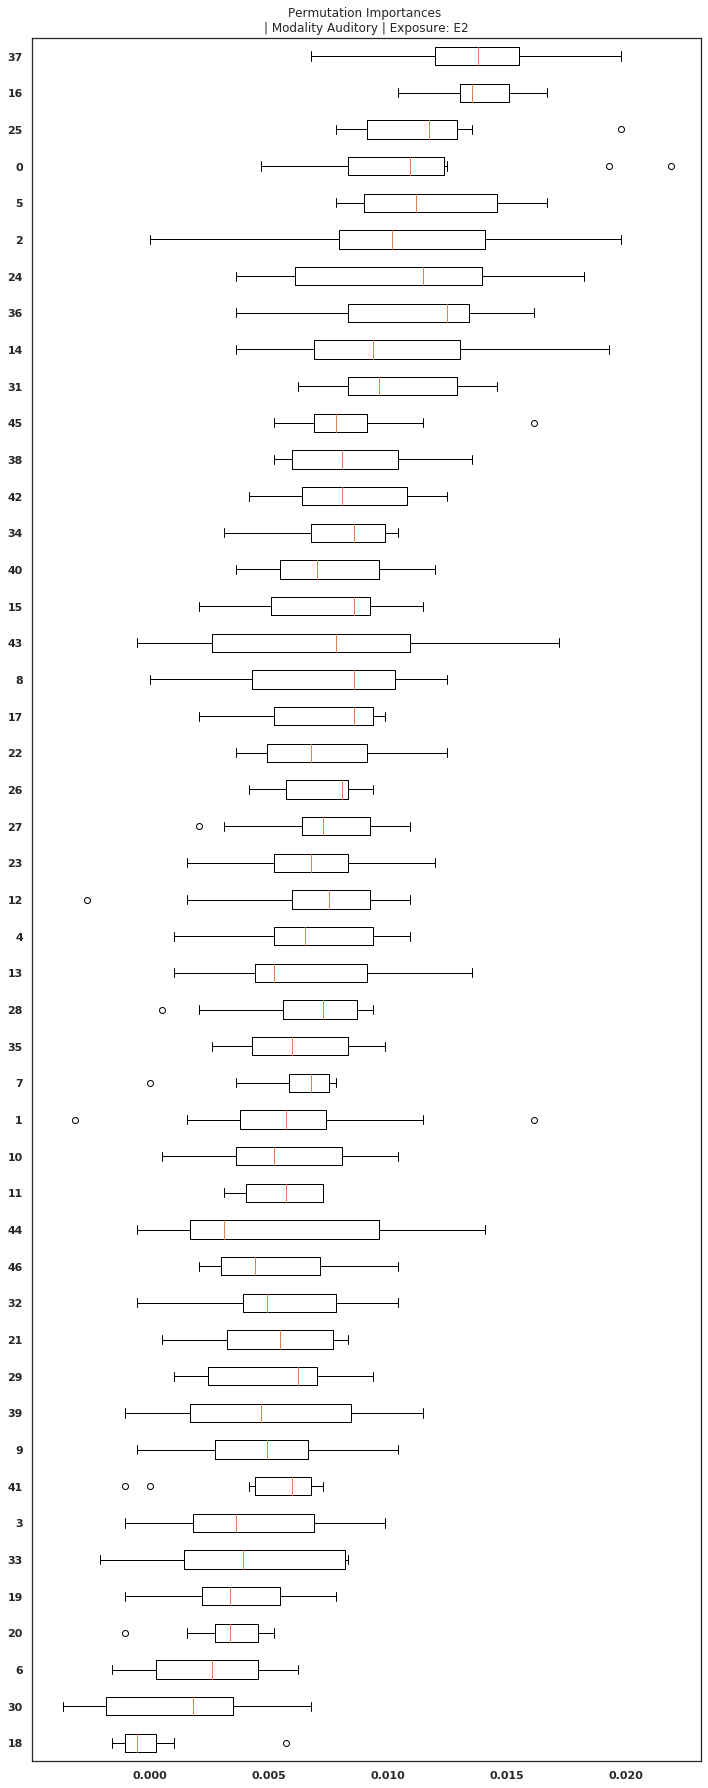

In [80]:
resu_aud_2_w_i = makeCatPlot_Inspeção(df_aud_2,'Auditory','E2')

# Export to autoencoder

In [81]:
def six_bin_data(data, indice):
    return six_bin(data, indice, False)

In [82]:
auto_enconder_aud_1 = list(map(six_bin_data, aud_expo_1, indice_s2_aud))
auto_enconder_vis_1 = list(map(six_bin_data, vis_expo_1, indice_s2_vis))

auto_enconder_aud_2 = list(map(six_bin_data, aud_expo_2, indice_s2_vis))
auto_enconder_vis_2 = list(map(six_bin_data, vis_expo_2, indice_s2_aud))